In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import collections
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
import itertools
from math import sqrt

tf.logging.set_verbosity(tf.logging.INFO)
%matplotlib inline

In [6]:
# Functions

# Load Dataset
def load_data(output_path, window_size, compute_RR_interval_feature, compute_wavelets):
    extension = '_' + str(window_size)
    if compute_wavelets:
        extension = extension + '_' + 'wv'
    if compute_RR_interval_feature:
        extension = extension + '_' + 'RR'
        extension = extension + '.csv'

    # Load training and eval data
    train_data = np.loadtxt(output_path + 'train_data' + extension, delimiter=",", dtype=float)
    train_labels =  np.loadtxt(output_path + 'train_label' + extension, delimiter=",",  dtype=np.int32)
    eval_data = np.loadtxt(output_path + 'eval_data' + extension, delimiter=",", dtype=float)
    eval_labels = np.loadtxt(output_path + 'eval_label' + extension, delimiter=",",  dtype=np.int32)

    return (train_data, train_labels, eval_data, eval_labels)

# Normalize data features
def normalize_data(train_data, eval_data):
    feature_size = len(train_data[0])

    max_wav = np.amax(np.vstack((train_data[:, 0:feature_size], eval_data[:, 0:feature_size])))
    min_wav = np.amin(np.vstack((train_data[:, 0:feature_size], eval_data[:, 0:feature_size])))

    train_data[:, 0:feature_size] = ((train_data[:,0:feature_size] - min_wav) / (max_wav - min_wav))
    eval_data[:, 0:feature_size] = ((eval_data[:,0:feature_size] - min_wav) / (max_wav - min_wav))

    return (train_data, eval_data)

# Compute accuracy
def compute_accuracy(m):
    classes = m.shape[0]
    acc = np.zeros(classes)
    acc_global = 0
    for c in range(0, classes):
        if sum(m[:,c]) > 0:
            acc[c] = float(m[c,c]) / float(sum(m[:,c]))
        acc_global = acc_global + m[c,c]
        print ('acc ' + str(c) + ': ' + str(acc[c]))

    acc_global = float(acc_global) / float(sum(sum(m)))
    print ('global acc = ' + str(acc_global))
    return acc, acc_global


# Model function for Estimator
def my_model_fn(features, targets, mode, params):
    targets_onehot = tf.one_hot(indices = targets, depth=params["num_classes"], on_value = 1)
    # Connect the first hidden layer to input layer
    # (features) with relu activation
    #first_hidden_layer = tf.contrib.layers.relu(features, 10)
    first_hidden_layer = tf.contrib.layers.fully_connected(features, params["h1"])
    # tf.nn.conv1d
    second_hidden_layer = tf.contrib.layers.fully_connected(first_hidden_layer, params["h2"])
    third_hidden_layer = tf.contrib.layers.relu(second_hidden_layer, params["h3"])

    # Connect the output layer to second hidden layer (no activation fn)
    output_layer = tf.contrib.layers.linear(third_hidden_layer, params["num_classes"])

    if mode == 'train' and params["weight_imbalanced"]:
        weights_tf = tf.constant(params["weights"])

    else:
        weights_tf = tf.ones([features.shape[0].value], tf.float32) 

    loss = tf.losses.softmax_cross_entropy(targets_onehot, output_layer, weights=weights_tf)
    train_op = tf.contrib.layers.optimize_loss(
    loss=loss,
    global_step=tf.contrib.framework.get_global_step(),
    learning_rate=params["learning_rate"],
    optimizer="SGD")

    correct_prediction = tf.equal(tf.argmax(targets_onehot, 1), tf.argmax(output_layer, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))   
    eval_metric_ops = {
        "accuracy": accuracy
        #tf.metrics.accuracy(targets_onehot, output_layer)
        #"rmse": tf.metrics.root_mean_squared_error(
        #    tf.cast(targets, tf.float64), predictions)
        }

    return model_fn_lib.ModelFnOps(
        mode=mode,
        predictions=output_layer,#predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops
        )

# Plot matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

=======INPUT=======
Counter({0: 45821, 2: 3788, 1: 943, 3: 414})
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A8E1206710>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\soma\\AppData\\Local\\Temp\\tmpkuzll_f0'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tens

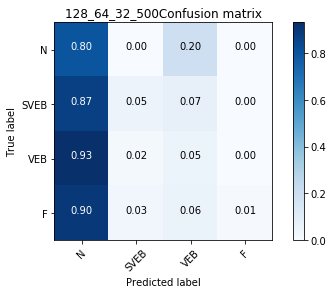

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002AB0991ED68>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\soma\\AppData\\Local\\Temp\\tmp7ev1d0ol'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\soma\AppData\Local\

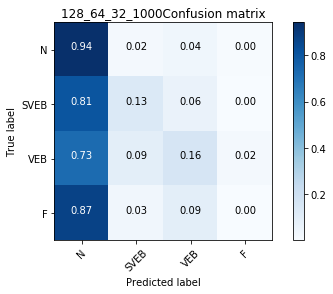

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A8ED4D4A90>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\soma\\AppData\\Local\\Temp\\tmpq9l5gze5'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\soma\AppData\Local\

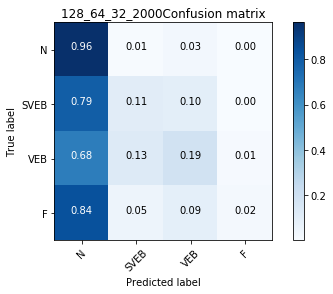

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A8D518FB00>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\soma\\AppData\\Local\\Temp\\tmpvymxlis1'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\soma\AppData\Local\

In [ ]:
window_size = 160
compute_RR_interval_feature = True
compute_wavelets = True
dataset = 'mit_db/'
output_path = 'trainedDataSet/'
weight_imbalanced = True
class_names = ["N", "SVEB", "VEB", "F"]


# 0 Load Data
train_data, train_labels, eval_data, eval_labels = load_data(output_path, window_size, compute_RR_interval_feature, compute_wavelets)

# 1 TODO Preprocess data? norm? if RR interval, last 4 features are pre, post, local and global RR
# Apply some norm? convolution? another approach?
# train_data, eval_data =  normalize_data(train_data, eval_data)

# 2 Create my own model
# Imbalanced class: weights
# https://www.tensorflow.org/api_guides/python/contrib.losses

# Learning rate for the model
LEARNING_RATE = 0.001
num_classes = 4
# Set model params

count = collections.Counter(train_labels)
print("=======INPUT=======")
print(count)
#total = 0
#max_class = 0
#for c in range(0,num_classes):
#    total += count[c]
#    if count[c] > max_class:
#        max_class = count[c]

#class_weight = np.zeros(num_classes)
#for c in range(0,num_classes):
#    if count[c] > 0:
        #class_weight[c] = 1- float(count[c]) / float(total)
#        class_weight[c] = float(max_class) / float(count[c]) # the class with more instance will have weight = 1, and the others x times ...

# TODO give more weigth to anomaly classes? We want to detect always these bad anomalies
#weights = np.zeros((len(train_labels)), dtype='float')

weights = np.random.randn(len(train_labels)) / sqrt(len(train_labels) / 2)

for i in range(0,len(train_labels)):
    weights[i] = class_weight[train_labels[i]]

hn_1 = [128, 64, 32]
hn_2 = [64, 32, 16]
hn_3 = [32, 16, 8]
steps = [500, 1000, 2000, 8000]


for h1 in hn_1:
    for h2 in hn_2:
        for h3 in hn_3:
            for s in steps:
                model_params = {
                "learning_rate": LEARNING_RATE, 
                "num_classes": num_classes, 
                "weights": weights, 
                "weight_imbalanced": weight_imbalanced, 
                "h1": h1,
                "h2": h2, 
                "h3": h3}

                nn = tf.contrib.learn.Estimator(model_fn=my_model_fn, params=model_params)

                def get_train_inputs():
                    x = tf.constant(train_data)
                    y = tf.constant(train_labels)
                    return x, y

                # Fit
                nn.fit(input_fn=get_train_inputs, steps=s)

                # Score accuracy
                def get_test_inputs():
                    x = tf.constant(eval_data)
                    y = tf.constant(eval_labels)
                    return x, y

                ev = nn.evaluate(input_fn=get_test_inputs, steps=1)["accuracy"]

                # Compute the matrix confussion
                predictions = list(nn.predict(input_fn=get_test_inputs))

                confusion_matrix = np.zeros((num_classes,num_classes), dtype='int')
                for p in range(0, len(predictions), 1):
                    ind_p = np.argmax(predictions[p])
                    confusion_matrix[ind_p][eval_labels[p]] = confusion_matrix[ind_p][eval_labels[p]] + 1

                acc, acc_g = compute_accuracy(confusion_matrix)
                
                plt.figure()
                plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True,
                                      title=str(h1) + '_' + str(h2) + '_' + str(h3) + '_' + str(s) +'Confusion matrix')

                plt.show()

                np.savetxt('result/' + 'nn_' + str(h1) + '_' + str(h2) + '_' + str(h3) + '_' + str(s) + '_cm.txt', confusion_matrix, fmt='%-7.0f')    
                np.savetxt('result/' + 'nn_' + str(h1) + '_' + str(h2) + '_' + str(h3) + '_' + str(s) + '_acc.txt', acc, fmt='%-7.2f')    